# Using akride Python client to interact with Akridata Data Explorer


### Step 1. Install akride client

NOTE: We are installing CPU optimized akride SDK for this use case, in case you have a GPU instance available, you can install `akride[gpu]`

In [ ]:
import sys

!{sys.executable} -m pip install 'akride[cpu]'  --ignore-installed --no-dependencies
# !{sys.executable} -m pip install 'akride[gpu]' # use this if GPU machine is available

## Setup Variables
Please set up the following variables to run the notebook with custom data


In [ ]:
APPLICATION_URL="https://app.akridata.ai"
#Get the sdk config by signing in to Data Explorer UI and navigating to Utilities → Get CLI/SDK config
API_KEY="akridata-api-key"


# Absolute/relative path to the directory which consists of images
IMAGE_DATA_DIR="../dataset/cata-dog-bird/"
#Name of the dataset
DATASET_NAME="cats-dogs-birds"

### Step 2. Initializing akride client

Get the sdk config by signing in to Data Explorer UI and navigating to Utilities → Get CLI/SDK config

In [35]:
from akride import AkriDEClient

# API Key Configurations
sdk_config_dict = {
  "saas_endpoint": APPLICATION_URL,
  "api_key": API_KEY,
  "mode": "saas"
}


client = AkriDEClient(sdk_config_dict=sdk_config_dict)

AkriDEClient initialized


###  Using the client

#### 1. Creating a dataset

Creates a dataset entity on Data Explorer

In [36]:
import random
import string
from akride.core.enums import DataType

#Create a random string of length 5 to enable re-run
rand_prefix = ''.join(random.choices(string.ascii_uppercase, k=5))
if DATASET_NAME == "cats-dogs-birds":
    dataset_name = f"{DATASET_NAME}-{rand_prefix}"
else:
    dataset_name = DATASET_NAME
dataset_spec = {"dataset_name": dataset_name, "data_type":DataType.IMAGE }
dataset = client.create_dataset(spec=dataset_spec )
print(f"Dataset {dataset.get_name()} created successfully with ID {dataset.get_id()}")

Dataset cats-dogs-birds-NDDJQ created successfully with ID eec3955c-e4f2-4c69-a529-0d67151966b4


#### 2. Ingest Dataset

Ingest the image data available locally

In [37]:
import os
import time
task = client.ingest_dataset(dataset=dataset, data_directory=os.path.join(os.getcwd(), "../dataset/cata-dog-bird/" ))
while task.has_completed() !=True:
    print(f"Current progress:{task.get_progress_info().percent_completed}")
    time.sleep(5)

2023-10-17 13:11:27,584,584 | INFO     | _pipeline_executor.py |   Thread-5 |          run:61 | Ingestion in progress!


Current progress:0.0


2023-10-17 13:11:28,828,828 | INFO     | ingest_partitioner_filter.py |   Thread-5 |          run:61 | Files to be ingested: 333


Current progress:25.0
Current progress:25.0
Current progress:25.0
Current progress:25.0


2023-10-17 13:11:48,183,183 | INFO     | data_ingest_filter.py |   Thread-5 |   run_common:224 | Projections df shape: (1, 333, 2)
2023-10-17 13:11:48,187,187 | INFO     | data_ingest_filter.py |   Thread-5 |   run_common:225 | Projections arr shape: (333, 1176)
2023-10-17 13:11:48,189,189 | INFO     | data_ingest_filter.py |   Thread-5 |   run_common:226 | Coreset shape: (1, 99, 3)
2023-10-17 13:11:48,193,193 | INFO     | data_ingest_filter.py |   Thread-5 |   run_common:227 | Sketch shape: (1, 24, 1280)


Current progress:25.0
Current progress:25.0
Current progress:25.0
Current progress:25.0


2023-10-17 13:12:12,331,331 | INFO     | _pipeline_executor.py |   Thread-5 |          run:76 | Ingestion completed!


#### 3. Create an Explore Job

In [38]:
from akride.core.enums import EmbedAlgoType,JobType,ClusterAlgoType

#Get dataset using dataset name
ds = client.get_dataset_by_name(name=dataset_name)
rand_prefix = ''.join(random.choices(string.ascii_uppercase, k=5))
job_name = f"{dataset_name}-explore-{rand_prefix}".upper()
job_spec = client.create_job_spec(dataset=ds, job_type=JobType.EXPLORE ,
                                  job_name=job_name, embed_algo=EmbedAlgoType.UMAP,
                                  cluster_algo=ClusterAlgoType.HDBSCAN,
                                  catalog_name="primary",
                                  num_clusters=6, max_images=500)

job = client.create_job(spec=job_spec)

In [39]:
import matplotlib.pyplot as plt

#Utility function
def display_grid(nrows, ncols, imgs, size):
    assert len(imgs) <= nrows*ncols
    fig = plt.figure(figsize=(size, size))
    for i, img in enumerate(imgs):
        fig.add_subplot(nrows, ncols, i + 1)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(img)
    plt.show()


#### Job Visualization

Fetch the job using job name



In [40]:
while True:
    job = client.get_job_by_name(job_name.upper())
    if job.info.status in ["READY", "FAILED"]: # type: ignore
        break
    else:
        print("Waiting for job completion")
        time.sleep(5)


View Clusters

cluster 1


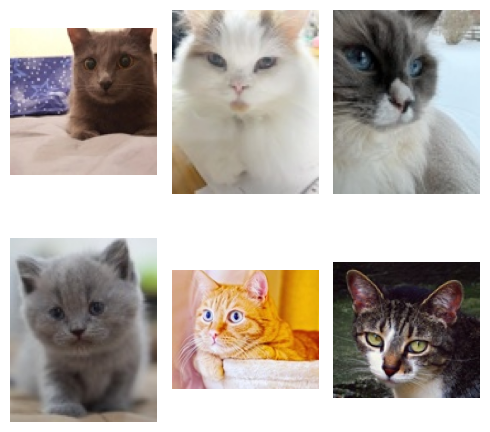

cluster 2


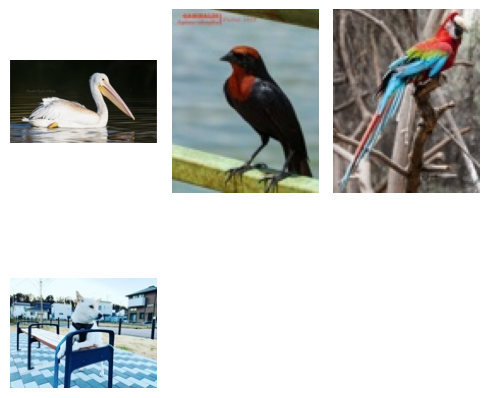

cluster 3


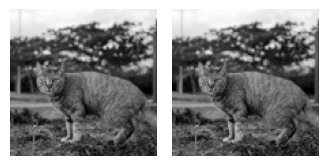

In [41]:
from akride import JobContext

nrows = 2
ncols = 3
max_count = nrows*ncols
for cluster_id in range(1,7):
    spec = {
        "cluster_id": cluster_id,
        "max_count": max_count,
    }
    samples = client.get_job_samples(
        job, JobContext.CLUSTER_RETRIEVAL, spec
    )

    if not len(samples):
        break
    imgs = client.get_thumbnail_images(samples)
    print(f"cluster {cluster_id}")
    display_grid(nrows, ncols, imgs, 5)

##### Perform coreset sampling


In [42]:
spec = {"percent": 10} #Retrieve 10% of coreset data
samples = client.get_job_samples(
    job, JobContext.CORESET_SAMPLING, spec)
thumbnails = client.get_thumbnail_images(samples=samples[:6])
print(f"Retrieved {len(samples)} samples")

Retrieved 33 samples


Showing a subset of data


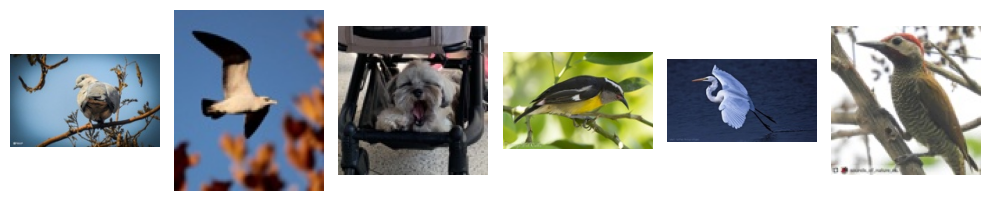

In [43]:
print("Showing a subset of data")
display_grid(1, 6, thumbnails, 10)

##### Perform a similarity Search
The code below shows how to perform a similarity search by using positive/negative re-enforcement to find images similar to the below image

<img src="../dataset/cata-dog-bird/dog/107.jpg" alt="MarineGEO circle logo" style="height: 500px; width:5d00px;"/>

Note that you can also specify the negative samples as specified below to improve the accuracy of the search

In [44]:
import os, akride
pos = [os.path.join(os.getcwd(), "../dataset/cata-dog-bird/", "dog/107.jpg" )]
neg = [os.path.join(os.getcwd(), "../dataset/cata-dog-bird/", "bird/100.jpg" )]
spec = {'positive_samples': pos, 'negative_samples': neg}
samples = client.get_job_samples(
    job, akride.JobContext.SIMILARITY_SEARCH, spec)


In [45]:
thumbnails = client.get_thumbnail_images(samples=samples)

print(f"Retrieved {len(thumbnails)} images")

Retrieved 16 images


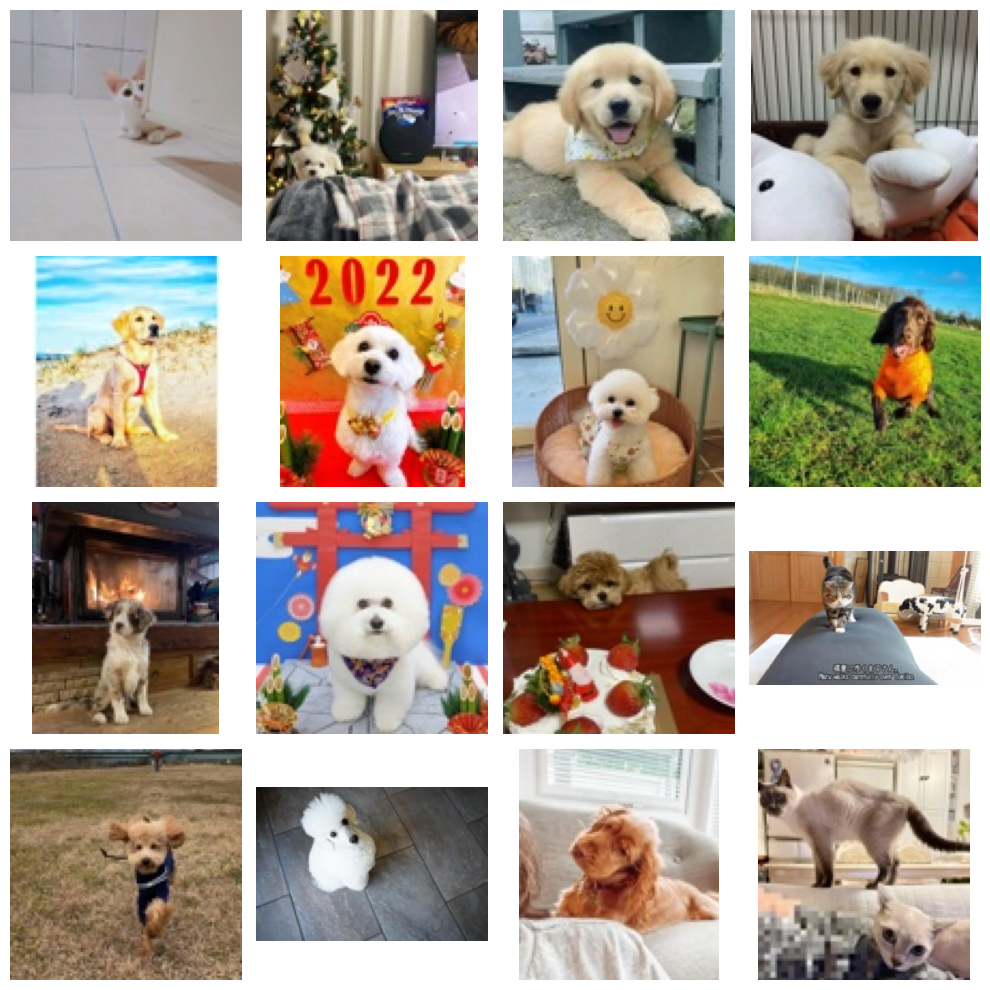

In [46]:
display_grid(4, 4, thumbnails, 10)



### Create a Resultset

In [47]:
resultset_name = "DOGS-RESULTSET-FROM-SIM-SEARCH"
resultset_spec = {"job": job, "name": resultset_name, "samples": samples}
resultset = client.create_resultset(resultset_spec)


#### Access the Resultset



In [48]:
resultset = client.get_resultset_by_name(resultset_name)


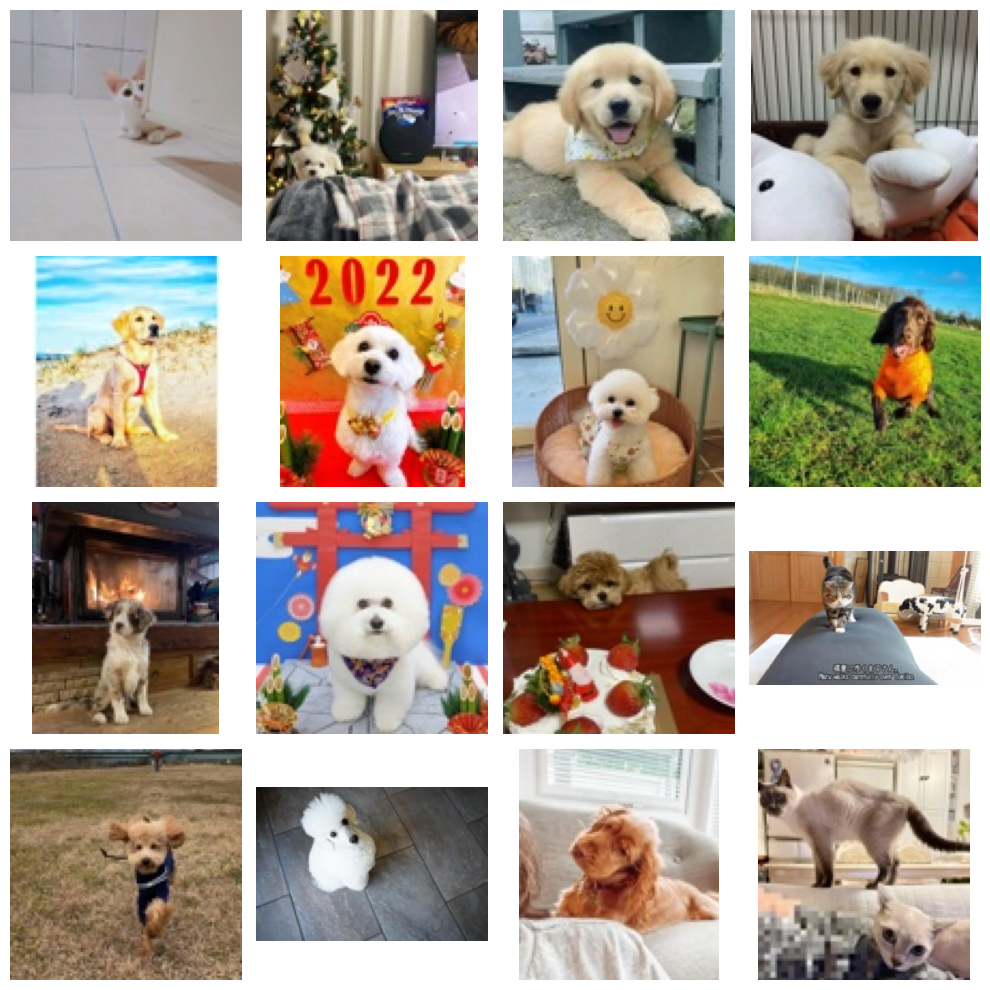

In [49]:
resultset_samples = client.get_resultset_samples(resultset=resultset) # type: ignore
resultset_images = client.get_thumbnail_images(resultset_samples)
display_grid(4, 4, thumbnails, 10)
